# Paper method implementation

This is our implementation of the paper *Neuroevolution of Self-Interpretable Agents*, which is the theory basis of our project. 

In this notebook, we implement the Self-Attention modthod on LSTM based on the CarRacing game in the Gym environment. 

## 1. Prepare the environment 

Install Gym and Gym[box2d] environments and other useful packages including display related tool which is needed for the game observation.

In [ ]:
!sudo apt-get update
!pip install gym
!pip install gym[box2d]
!apt install python-opengl
!apt install ffmpeg
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*
!pip install cma

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
Get:12 https://developer.downl

In [ ]:
import os
from typing import Dict, List, Tuple

import gym
from gym import spaces
from gym.envs.box2d.car_dynamics import Car
from pyvirtualdisplay import Display

import pyglet
from pyglet import gl

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output

import cma
from torchvision import transforms

Load CarRacing environment from gym, and we can see that the observation is a image screen with the shape of 96*96*3. The action space is 3*1, with each value ranges from -1 to 1, which is not discrete.

In [ ]:
env = gym.make('CarRacing-v0')
env = gym.wrappers.Monitor(env, "videos", force=True)

print(env.action_space)
print(env.observation_space)

Box(-1.0, 1.0, (3,), float32)
Box(0, 255, (96, 96, 3), uint8)


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Track generation: 1304..1634 -> 330-tiles track


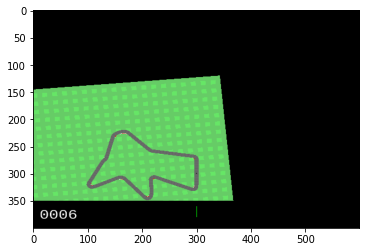

In [ ]:
render = True
n_episodes = 1

from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 600))
display.start()

env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

In [ ]:
# https://github.com/nbgraham/RL-Race-Car-Simulator
render = True
n_episodes = 1

rewards = []
observation_list = []
render_list = []
for i_episode in range(n_episodes):
    observation = env.reset()
    sum_reward = 0
    for t in range(1000):
        if render:
            render_list.append(env.render(mode='rgb_array'))
        # [steering, gas, brake]
        action = env.action_space.sample()
        # observation is 96x96x3
        observation, reward, done, _ = env.step(action)
        observation_list.append(observation)
        #print(len(observation))
        #print(len(observation[0]))
        #print(len(observation[0][0]))
        #print(observation)
        # break
        sum_reward += reward
        if(t % 100 == 0):
            print(t)
        if done or t == 999:
            print("Episode {} finished after {} timesteps".format(i_episode, t+1))
            print("Reward: {}".format(sum_reward))
            rewards.append(sum_reward)
        if done:
            break

Track generation: 963..1208 -> 245-tiles track
0
100
200
300
400
500
600
700
800
900
Episode 0 finished after 1000 timesteps
Reward: -22.131147540983733


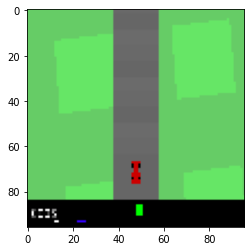

In [ ]:
plt.imshow(observation_list[100])

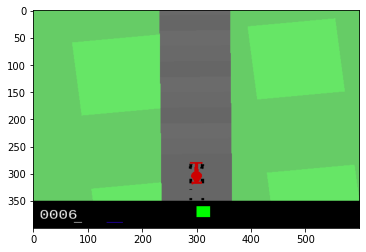

In [ ]:
plt.imshow(render_list[100])

## 2.Define Model


### 1) Create Base Module

The base model contains basic functions, including setting the weights of the network.

In [ ]:
class BaseModule(nn.Module):
    """Base class for all Module."""

    def __init__(self):
        self._layers = []
        super(BaseModule, self).__init__()

    def get_output(self, inputs, update_filter=False):
        torch.set_num_threads(1)
        with torch.no_grad():
            return self._get_output(inputs, update_filter)

    def _get_output(self, inputs, update_filter):
        raise NotImplementedError()

    def get_params(self):
        params = []
        for layer in self._layers:
            weight_dict = layer.state_dict()
            for k in sorted(weight_dict.keys()):
                #params.append(weight_dict[k].cuda().data.cpu().numpy().copy().ravel())
                params.append(weight_dict[k].cpu().numpy().copy().ravel())
        return np.concatenate(params)

    def set_params(self, params):
        offset = 0
        for i, layer in enumerate(self._layers):
            weights_to_set = {}
            weight_dict = layer.state_dict()
            for k in sorted(weight_dict.keys()):
                weight = weight_dict[k].cpu().numpy()
                weight_size = weight.size
                weights_to_set[k] = params[offset:(offset + weight_size)].reshape(weight.shape)
                offset += weight_size
            self._layers[i].load_state_dict(state_dict=weights_to_set)

    def get_params_from_layer(self, layer_index):
        params = []
        layer = self._layers[layer_index]
        weight_dict = layer.state_dict()
        for k in sorted(weight_dict.keys()):
            params.append(weight_dict[k].numpy().copy().ravel())
        return np.concatenate(params)

    def set_params_to_layer(self, params, layer_index):
        weights_to_set = {}
        weight_dict = self._layers[layer_index].state_dict()
        offset = 0
        for k in sorted(weight_dict.keys()):
            weight = weight_dict[k].numpy()
            weight_size = weight.size
            weights_to_set[k] = torch.from_numpy(
                params[offset:(offset + weight_size)].reshape(weight.shape)).cuda().data.cpu().numpy()
            offset += weight_size
        self._layers[layer_index].load_state_dict(state_dict=weights_to_set)

    def get_num_params_per_layer(self):
        num_params_per_layer = []
        for layer in self._layers:
            weight_dict = layer.state_dict()
            num_params = 0
            for k in sorted(weight_dict.keys()):
                weights = weight_dict[k].numpy()
                num_params += weights.size
            num_params_per_layer.append(num_params)
        return num_params_per_layer

    def _save_to_file(self, filename):
        params = self.get_params()
        np.savez(filename, params=params)

    def save(self, log_dir, iter_count, best_so_far):
        filename = os.path.join(log_dir, 'model_{}.npz'.format(iter_count))
        self._save_to_file(filename=filename)
        if best_so_far:
            filename = os.path.join(log_dir, 'best_model.npz')
            self._save_to_file(filename=filename)

    def load(self, filename):
        with np.load(filename) as data:
            params = data['params']
            self.set_params(params)

    def reset(self):
        raise NotImplementedError()

    @property
    def layers(self):
        return self._layers

### 2) Self-attention Module

In the self-attention network, the input data will be flattened and are operated with multiplication to get the importance matrix and k top patches will be selected as important positions for later operations.

In [ ]:
#https://github.com/google/brain-tokyo-workshop/blob/master/AttentionAgent/solutions/torch_solutions.py
class SelfAttention(nn.Module):
    """A simple self-attention solution."""

    def __init__(self, data_dim, dim_q):
        super(SelfAttention, self).__init__()
        self._layers = []
        self.fc_q = nn.Linear(data_dim, dim_q).cuda()
        self._layers.append(self.fc_q)
        self.fc_k = nn.Linear(data_dim, dim_q).cuda()
        self._layers.append(self.fc_k)

    def forward(self, input_data):
        # Expect input_data to be of shape (b, t, k).
        b, t, k = input_data.size()

        # Linear transforms.
        queries = self.fc_q(input=input_data.cuda())  # (b, t, q)
        keys = self.fc_k(input=input_data.cuda())  # (b, t, q)

        # Attention matrix.
        dot = torch.bmm(queries, keys.transpose(1, 2))  # (b, t, t)
        scaled_dot = torch.div(dot, torch.sqrt(torch.tensor(k).float())) # scale
        return scaled_dot
    @property
    def layers(self):
        return self._layers

### 3) LSTM Module

This network helps to make prediction on actions based input observations. The inputs are those selected ones from the self-attention model.

In [ ]:
class LSTM(nn.Module):
    """LSTM layers."""

    def __init__(self, input_dim, num_units, output_dim):
        super(LSTM, self).__init__()
        self._layers = []
        self.hidden_layers = 1
        self.hidden_size = num_units[0] if len(num_units) else output_dim
        self.hidden = (
            torch.zeros((self.hidden_layers, 1, self.hidden_size)).cuda(),
            torch.zeros((self.hidden_layers, 1, self.hidden_size)).cuda(),
        )
        
        # define LSTM
        self.lstm = nn.LSTM(
            input_size=input_dim, # expected input features number
            hidden_size=self.hidden_size, # hidden state features number
            num_layers=self.hidden_layers, # hidden layers number
        ).cuda()
        self._layers.append(self.lstm)

        # applies a linear transformation to the incoming data
        fc = nn.Linear(
            in_features=self.hidden_size,
            out_features=output_dim,
        ).cuda()
        self._layers.append(fc)
        

    def forward(self, input_data):
        x_input = input_data
        x_output, self.hidden = self._layers[0](
            x_input.view(1, 1, -1), self.hidden)
        x_output = torch.flatten(x_output, start_dim=0, end_dim=-1)
        x_output = self._layers[-1](x_output)
        return x_output

    def reset(self):
        # reset weights in hidden layers
        self.hidden = (
            torch.zeros((self.hidden_layers, 1, self.hidden_size)).cuda(),
            torch.zeros((self.hidden_layers, 1, self.hidden_size)).cuda(),
        )

    @property
    def layers(self):
        return self._layers

### 4) MLP Module

MLP model intialize the LSTM network to make preditions, and also processes on the input and output for agent to use.

In [ ]:
class MLPModule(BaseModule):
    """Multi-layer perception."""
    def __init__(self, input_dim, num_hiddens, output_dim, output_activation, l2_coefficient):
        super(MLPModule, self).__init__()
        self.output_dim = output_dim
        self.output_activation = output_activation
        self.l2_coefficient = abs(l2_coefficient)
        
        # use LSTM module
        self.fc_stack = LSTM(
            input_dim=input_dim,
            num_units=num_hiddens,
            output_dim=output_dim,
        ).cuda()

        self._layers = self.fc_stack.layers

    def get_output(self, inputs, updates_filter=False):
        # get input
        if not isinstance(inputs, torch.Tensor):
            inputs = torch.from_numpy(inputs).float()

        # apply to LSTM   
        fc_output = self.fc_stack(inputs)

        # set activation function to be tanh
        output = torch.tanh(fc_output).squeeze().detach().cpu().numpy()

        return output

    def reset(self):
        if hasattr(self.fc_stack, 'reset'):
            self.fc_stack.reset()
            print('hidden reset.')

### 5) AttentionAgent

Agent will send the observation to the previous defined models and make prediction on actions to make based on the result from them. The observation 96 * 96 * 3 will be segmented into 7 * 7 * 3 patched, and they will be processed by the self-attention model. Top k patched will be processed to affect the decision making. When an action is made, it will update to a new observation.

In [ ]:
class AttentionAgent(BaseModule):
  """Selective Attention Model"""
  def __init__(self, image_size, patch_size, patch_stride, top_k, data_dim, query_dim, num_hiddens, output_dim):
    super(AttentionAgent, self).__init__()
    self.image_size = image_size
    self.patch_size = patch_size
    self.patch_stride = patch_stride
    self.top_k = top_k

    self.transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ])
    
    #get patch center location
    n = int((image_size - patch_size) / patch_stride + 1)
    offset = self.patch_size // 2
    patch_centers = []
    for i in range(n):
        patch_center_row = offset + i * patch_stride
        for j in range(n):
            patch_center_col = offset + j * patch_stride
            patch_centers.append([patch_center_row, patch_center_col])
    self.patch_centers = torch.tensor(patch_centers).float()
    num_patches = n ** 2
    
    #define attention layers
    self.attention = SelfAttention(
        data_dim=data_dim * self.patch_size ** 2,
        dim_q=query_dim,
    ).cuda()
    print(self.attention)
    self._layers.extend(self.attention.layers)

    #define controller
    self.controller = MLPModule(
        input_dim=self.top_k * 2,
        num_hiddens=num_hiddens,
        output_dim=output_dim,
        output_activation="tanh",
        l2_coefficient=0,
    ).cuda()
    print(self.controller.layers)
    self._layers.extend(self.controller.layers)

  def temp(self):
    print(self.input_dim,self.output_dim,self.num_hiddens)

  def get_result(self, inputs):
    # -------Input Transformation--------
    # observation.shape = (h, w, c)
    observation = self.transform(inputs).permute(1, 2, 0)
    h, w, c = observation.size()
    # dim = (18, 96, 3, 7) -> (18, 7, 96, 3) if image size = 96
    patches = observation.unfold(0, self.patch_size, self.patch_stride).permute(0, 3, 1, 2)
    # dim = (18, 7, 18, 3, 7) -> (18, 18, 7, 7, 3) if image size = 96
    patches = patches.unfold(2, self.patch_size, self.patch_stride).permute(0, 2, 1, 4, 3)
    # dim = (324, 7, 7, 3) if image size = 96
    patches = patches.reshape((-1, self.patch_size, self.patch_size, c))
    # flattened_patches.shape = (1, n, p * p * c)
    flattened_patches = patches.reshape((1, -1, c * self.patch_size ** 2))

    # -------Importance voting-------
    # attention_matrix.shape = (1, n, n)
    attention_matrix = self.attention(flattened_patches)
    # patch_importance_matrix.shape = (n, n)
    patch_importance_matrix = torch.softmax(attention_matrix.squeeze(), dim=-1)
    # patch_importance.shape = (n,)
    patch_importance = patch_importance_matrix.sum(dim=0)

    # -------Patch Selection and Feature Extraction-------
    # extract top k important patches
    patch_importance_sort_index = torch.argsort(patch_importance, descending=True)
    top_k_patch_index = patch_importance_sort_index[:self.top_k]
    # get top k important patches' centers position
    centers = self.patch_centers[top_k_patch_index]
    centers = centers.flatten(0, -1)
    # normalize position
    centers = centers / self.image_size
    centers = centers.cuda()

    # get action
    return self.controller.get_output(centers)


## 3.Neuroevolution of the Agent(CMA-ES)


CMA-ES algorithm is used for optimization. 
GUIDE link here：https://blog.otoro.net/2017/10/29/visual-evolution-strategies/

In [ ]:
!git clone https://github.com/hardmaru/estool.git
import sys
sys.path.append("/content/estool/")
from es import CMAES

import numpy as np
import matplotlib.pyplot as plt

fatal: destination path 'estool' already exists and is not an empty directory.


In [ ]:
class CMA(CMAES):
    """CMA algorithm."""

    def __init__(self, seed, population_size, init_sigma, init_params):
        """Create a wrapper of cmapy."""

        self._algorithm = cma.CMAEvolutionStrategy(
            x0=init_params,
            sigma0=init_sigma,
            inopts={
                'popsize': population_size,
                'seed': seed if seed > 0 else 42,  # ignored if seed is 0
                'randn': np.random.randn,
            },
        )
        self._population = None

    def get_result(self):
      return super.result()

    def get_population(self):
        self._population = self._algorithm.ask()
        return self._population

    def evolve(self, fitness):
        self._algorithm.tell(self._population, -fitness)

    def get_current_parameters(self):
        return self._algorithm.result.xfavorite

## 4.Training

Start to train the agent with given image size 96*96, and the patch size is 7. With patch stride 5, we can get 529 patches in total, among which we will select top 5 to to process. The self-attention and the LSTM will be trained to select important patches reasonably and make predictions, respectively. And as there only need to train with selected patched, the trainable parameter are much fewer compared to those in regular training. 

In [ ]:
IMAGE_SIZE = 96
PATCH_SIZE = 7
PATCH_STRIDE = 5
TOP_K = 5
DATA_DIM = 3
QUERY_DIM = 4
NUM_HIDDENS = [16,]
OUTPUT_DIM = 3

agent = AttentionAgent(IMAGE_SIZE, PATCH_SIZE, PATCH_STRIDE, TOP_K, DATA_DIM, QUERY_DIM, NUM_HIDDENS, OUTPUT_DIM)

SelfAttention(
  (fc_q): Linear(in_features=147, out_features=4, bias=True)
  (fc_k): Linear(in_features=147, out_features=4, bias=True)
)
[LSTM(10, 16), Linear(in_features=16, out_features=3, bias=True)]


In [ ]:
# use gpu to train
agent = agent.cuda()

In [ ]:
a = agent.get_params()
a.shape

(3027,)

In [ ]:
action_high = np.array([1., 1., 1.])
action_low = np.array([-1., 0., 0.])
def roll_out(params):

  agent.set_params(params)
  render = False
  n_episodes = 1

  rewards = []

  for i_episode in range(n_episodes):
      observation = env.reset()
      sum_reward = []
      done = False
      while not done:
          # [steering, gas, brake]
          #action = agent.get_result(env.render(mode='rgb_array'))
          action = agent.get_result(observation)
          action = (action * (action_high - action_low) / 2. + (action_high + action_low) / 2.)
          # observation is 96x96x3
          observation, reward, done, _ = env.step(action)
          
          sum_reward.append(reward)

      actual_reward = np.sum(sum_reward)
      rewards.append(actual_reward)
  return np.array(rewards).sum()/n_episodes

In [ ]:
SEED = 0
POPULATION_SIZE = 256
INIT_SIGMA = 0.1

In [ ]:
#https://github.com/google/brain-tokyo-workshop/blob/master/AttentionAgent/algorithms/cma.py
#https://github.com/hardmaru/estool/blob/master/simple_es_example.ipynb
import cma
# defines CMA-ES algorithm solver
cmaes = CMAES(agent.get_params(),
              popsize=POPULATION_SIZE,
              weight_decay=0.1,
              sigma_init = INIT_SIGMA
          )

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 3027 (seed=253794, Fri Apr 23 08:15:34 2021)


In [ ]:
MAX_ITERATION = 2000
history = []
reward = []

# tran loop
for j in range(MAX_ITERATION):
  solutions = torch.from_numpy(cmaes.ask()).cuda()
  fitness_list = torch.from_numpy(np.zeros(POPULATION_SIZE)).cuda()

  for i in range(POPULATION_SIZE):
    print("pop:",i+1)
    fitness_list[i] = roll_out(solutions[i,:])

  cmaes.tell(fitness_list.cpu())
  result = cmaes.result() # first element is the best solution, second element is the best fitness

  history.append(result[1])
  reward.append((roll_out(torch.from_numpy(result[0]).cuda())))

  if (j+1) % 1 == 0:
    print("fitness at iteration", (j+1), history[j])
    print("current reward", reward[j])

print("Finished!")
agent.set_params(cmaes.result.xfavorite)

pop: 1
Track generation: 1114..1397 -> 283-tiles track
pop: 2
Track generation: 1176..1475 -> 299-tiles track
pop: 3
Track generation: 1175..1473 -> 298-tiles track
pop: 4
Track generation: 1113..1404 -> 291-tiles track
pop: 5
Track generation: 993..1251 -> 258-tiles track
pop: 6
Track generation: 1218..1534 -> 316-tiles track
pop: 7
Track generation: 1103..1387 -> 284-tiles track
pop: 8
Track generation: 1020..1280 -> 260-tiles track
pop: 9
Track generation: 1108..1389 -> 281-tiles track
pop: 10
Track generation: 1129..1423 -> 294-tiles track
Track generation: 1276..1598 -> 322-tiles track
fitness at iteration 1 16.732468434591897
current reward -34.57943925233664
pop: 1
Track generation: 1108..1389 -> 281-tiles track
pop: 2
Track generation: 1132..1419 -> 287-tiles track
pop: 3
Track generation: 1003..1262 -> 259-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1228..1539 -> 311-tiles track
pop: 4
Track generation: 1224..15

# Reference

Here is our implementation reference:
- https://github.com/google/brain-tokyo-workshop/tree/master/AttentionAgent
- https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/2b3f06b04b5e96e4772746c20fcb4dcc/reinforcement_q_learning.ipynb#scrollTo=30NQYxKuolfC